In [13]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [14]:
data=pd.read_csv('movie_actor_network.csv', index_col=False, names=['movie','actor'])
edges = [tuple(x) for x in data.values.tolist()]
data.head()


,movie,actor
0,m1,a1
1,m2,a1
2,m2,a2
3,m3,a1
4,m3,a3


In [15]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')
A=[B.subgraph(c).copy() for c in nx.connected_components(B)][0]#https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html


In [16]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


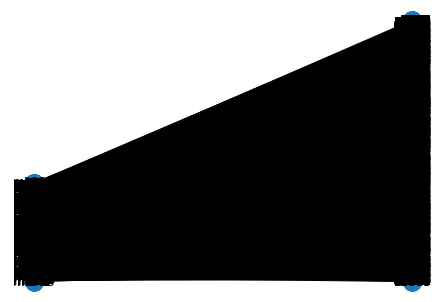

In [17]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))

nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [18]:
movies = []#number of movies and actor nodes
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))



number of movies  1292
number of actors  3411


In [19]:

# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [20]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [21]:
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.nodes[node_id]['label'] for node_id in node_ids]
node_embeddings.shape


(4703, 128)

In [22]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for i in range(len(node_ids)):
        if "a" in node_ids[i]:
            actor_embeddings.append(node_embeddings[i])
            actor_nodes.append(node_ids[i])
        else:
            movie_embeddings.append(node_embeddings[i])
            movie_nodes.append(node_ids[i])
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


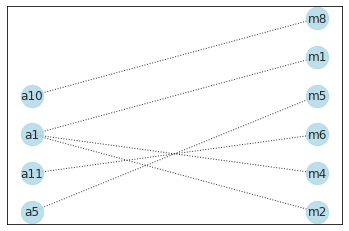

In [23]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

In [24]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

In [25]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

In [30]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [31]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

In [28]:
def cost1(graph,k):
    largest_cc = len(max(nx.connected_components(graph), key=len)) #finds largest connected component
    l=(graph.number_of_nodes())
    return (largest_cc)/k*1/l

In [29]:
def cost2(graph,k):
    '''In this function, we will calculate cost1'''
    count=0
    l=graph.number_of_edges()
    for i in graph.nodes():
        if "m" in i:
            count+=1
    cost2=1/k*(l/count) # calculate cost2
    return cost2

In [32]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

In [36]:
from tqdm import tqdm
k=[5,8,10,13,15,17,20,21,23,25,30,40,45,50,60,70,100,150]

a=pd.DataFrame()
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings=data_split(node_ids,node_targets,node_embeddings)
a["actor_id"]=actor_nodes
a.reset_index(drop=True, inplace=True)
for i in ((k)):
    algo=KMeans(n_clusters=i)
    j=algo.fit(actor_embeddings)
    a["cluster_number"]=j.labels_
    sum_cost_1=0
    sum_cost_2=0
    no_of_nodes=0
    for j in range(i):#graph of each cluster in (i)
        v=[]
        V=pd.DataFrame()
        X=pd.DataFrame()    
        x=[]
        edge=[]
        v.extend(np.array(a[a['cluster_number']==j]["actor_id"].values))
        V["actors"]=v
        for f in v:
            x.extend(data[data["actor"]==f]["movie"].values)
            edge.extend([tuple(x) for x in data[data["actor"]==f].values.tolist()])
        X["movies"]=x
        B=nx.Graph()
        B.add_nodes_from(V["actors"].unique(),bipartite=1)
        B.add_nodes_from(X["movies"].unique(),bipartite=0)#graph for each cluster in k
        B.add_edges_from(edge, label='acted')
        sum_cost_1+=cost1(B,i)
        sum_cost_2+=cost2(B,i)

    print("for k={0} cost={1}".format(i,sum_cost_1*sum_cost_2))

for k=5 cost=2.9881642991224706
for k=8 cost=2.3699257314409703
for k=10 cost=2.2220224925177954
for k=13 cost=2.0411056527541325
for k=15 cost=1.977283517746512
for k=17 cost=2.092785500052158
for k=20 cost=1.7836285497811484
for k=21 cost=1.8967574961714178
for k=23 cost=1.7578574211453106
for k=25 cost=1.774020660580681
for k=30 cost=1.7222334992765258
for k=40 cost=1.6169212407621647
for k=45 cost=1.5850374873900832
for k=50 cost=1.7875489492469407
for k=60 cost=1.4692917082868535
for k=70 cost=1.6117484110057436
for k=100 cost=1.5036017716859618
for k=150 cost=1.6140874610083111


In [ ]:
optimal number_of_cluster=5 with highest cost=2.988

In [38]:
algo=KMeans(n_clusters=5)
j=algo.fit(actor_embeddings)
a["cluster_number"]=j.labels_
print(a.head())


  actor_id  cluster_number
0     a973               4
1     a967               3
2    a1731               3
3     a964               4
4     a970               4


In [39]:
from sklearn.manifold import TSNE
X = np.array(actor_embeddings)
X_embedded = TSNE(n_components=2).fit_transform(X) 
X_embedded.shape


(3411, 2)

In [43]:
X_embedded[:5]

array([[ 48.463547,  33.687977],
       [ 46.71799 ,  39.880245],
       [-32.91782 ,  57.67313 ],
       [ 48.73027 ,  33.826344],
       [ 48.885513,  35.211357]], dtype=float32)

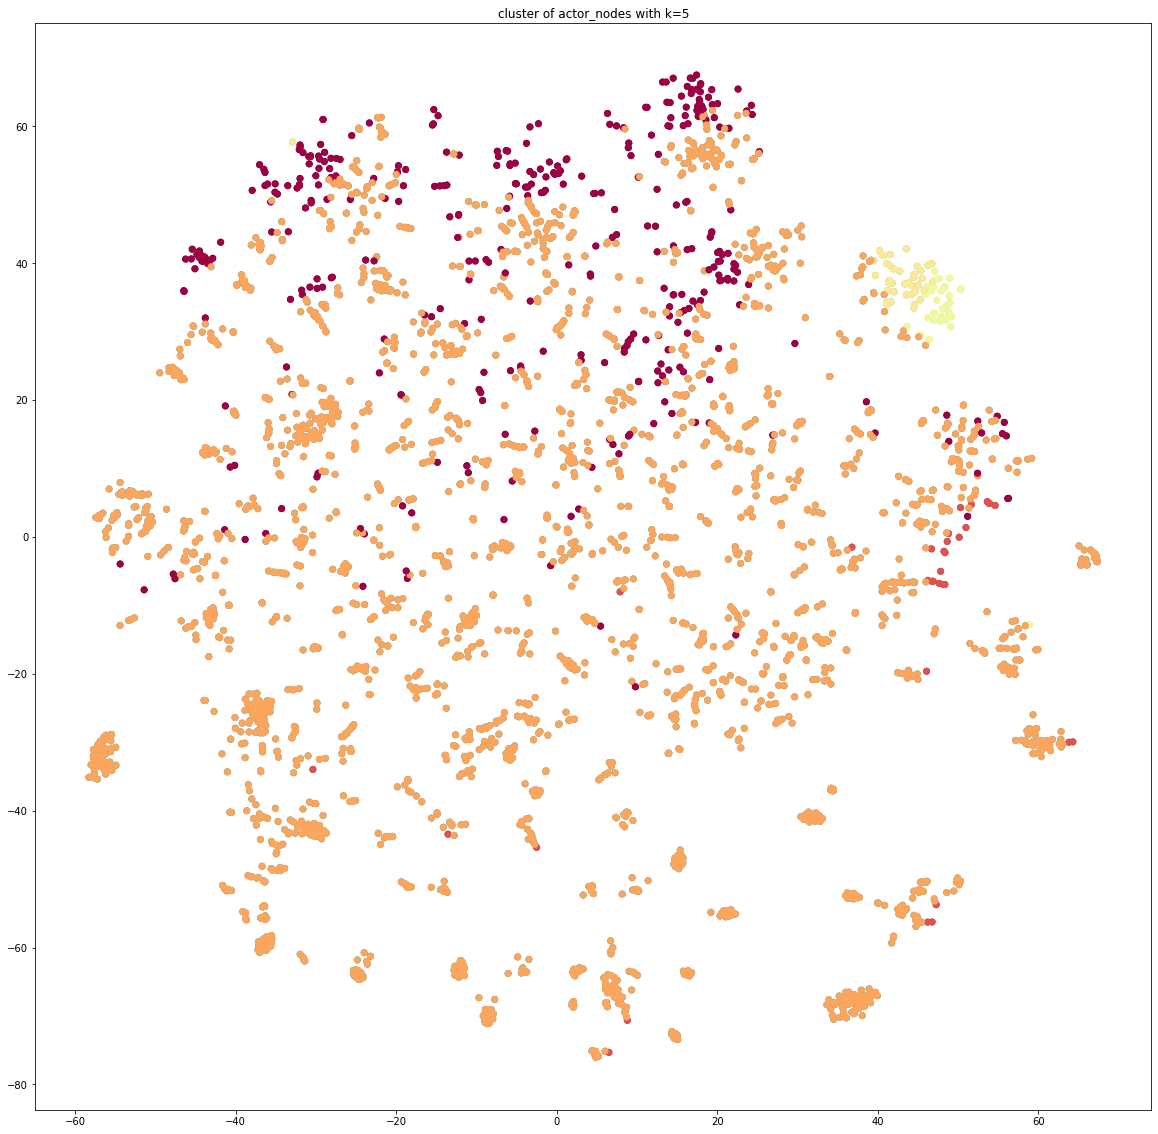

In [44]:
#https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster
import matplotlib
plt.figure(figsize=(20, 20))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=j.labels_.astype(float))
plt.scatter(X_embedded[:,0],X_embedded[:,1], c=[matplotlib.cm.Spectral(float(i) /7) for i in j.labels_]);   
plt.title("cluster of actor_nodes with k=5")
plt.show()

In [47]:
k_2=[5,8,10,13,15,17,20,21,23,25,30,40,45,50,60,70,100,150]
b=pd.DataFrame()
b["movie_id"]=movie_nodes
b.reset_index(drop=True, inplace=True)
for i in ((k_2)):
    algo=KMeans(n_clusters=i)
    j=algo.fit(movie_embeddings)
    b["cluster_number"]=j.labels_
    sum_cost_1=0
    sum_cost_2=0
    no_of_nodes=0
    for j in range(i):
        v=[]
        V=pd.DataFrame()
        X=pd.DataFrame()    
        x=[]
        edge=[]
        v.extend(np.array(b[b['cluster_number']==j]["movie_id"].values))
        V["movies"]=v
        for f in v:
            x.extend(data[data["movie"]==f]["actor"].values)
            edge.extend([tuple(x) for x in data[data["movie"]==f].values.tolist()])
        X["actors"]=x
        B=nx.Graph()
        B.add_nodes_from(V["movies"].unique(),bipartite=1)
        B.add_nodes_from(X["actors"].unique(),bipartite=0)
        B.add_edges_from(edge, label='acted')
        sum_cost_1+=cost1(B,i)
        sum_cost_2+=cost2(B,i)

    print(" k={0} cost={1}".format(i,sum_cost_1*sum_cost_2))

 k=5 cost=8.67395237450015
 k=8 cost=9.207151394396924
 k=10 cost=9.240195628245086
 k=13 cost=9.75086108352129
 k=15 cost=9.447317415826022
 k=17 cost=9.655794669458663
 k=20 cost=10.47551750531563
 k=21 cost=13.887209121263949
 k=23 cost=10.28473589561782
 k=25 cost=13.407012995700299
 k=30 cost=10.023532275808087
 k=40 cost=13.69890500572278
 k=45 cost=13.161365864883365
 k=50 cost=13.809617375228264
 k=60 cost=13.67315927285057
 k=70 cost=13.98046375680431
 k=100 cost=14.16260884311608
 k=150 cost=13.28386173666725


In [ ]:
optimal number_of_cluster=100 with highest cost=14.16